## 下载数据

In [126]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from collections import Counter

In [128]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='D:/xmy/6.5数据集（CIFAR10数据集）',train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='D:/xmy/6.5数据集（CIFAR10数据集）',train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 随机查看部分数据图像

In [131]:
import matplotlib.pyplot as plt
import numpy as np

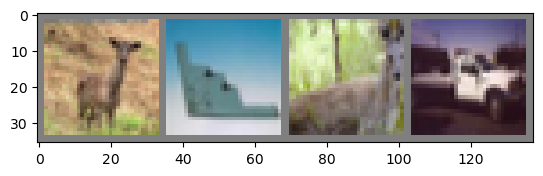

 deer plane  deer truck


In [133]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# 随机获取部分训练集    
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示4张图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 定义超参数

In [142]:
BATCHSIZE=100
DOWNLOAD_MNIST=False
EPOCHES=20
LR=0.001

## 构建网络框架

In [145]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### LeNet网络架构

In [148]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

### CNN网络架构

In [151]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(1296, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 36*6*6)  #不改变x的数据，但是按照我自己的意愿将其修改为二维张量，其第二维度为36*6*6=1296，以方便能够输入全连接层
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x

### Net网络架构

In [154]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, 1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 36, 5, 1)
        self.pool2 = nn.MaxPool2d(2,2)
        # 使用全局平均池化层
        self.app = nn.AdaptiveAvgPool2d(1)
        self.fc3 = nn.Linear(36, 10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.app(x)
        x = x.view(x.shape[0], -1)
        x = self.fc3(x)
        return x

In [156]:
net1 = CNNNet()
net2=Net()
net3=LeNet()

## 集成方法

In [159]:
mlps = [net1.to(device),net2.to(device),net3.to(device)]
#optimizer = torch.optim.Adam([{"params":mlp.parameters()} for mlp in mlps], lr = LR)
optimizer = torch.optim.Adam([param for mlp in mlps for param in mlp.parameters()], lr=LR)
loss_function = nn.CrossEntropyLoss()

for ep in range(EPOCHES):
    for img, label in trainloader:
        img,label = img.to(device),label.to(device)
        optimizer.zero_grad()
        for mlp in mlps:
            mlp.train()
            out = mlp(img)
            loss = loss_function(out, label)
            loss.backward()
        optimizer.step()
        
    pre = []
    vote_correct = 0
    mlps_correct = [0 for i in range(len(mlps))]
    for img, label in testloader:
        img,label = img.to(device),label.to(device)
        for i,mlp in enumerate(mlps):
            mlp.eval()
            out = mlp(img)

            _,prediction = torch.max(out, 1)
            pre_num = prediction.cpu().numpy()
            mlps_correct[i] += (pre_num==label.cpu().numpy()).sum()
            pre.append(pre_num)
        arr = np.array(pre_num)
        pre.clear()
        result = [Counter(arr[:i]).most_common(1)[0][0] for i in range(BATCHSIZE)]
        vote_correct += (result == label.cpu().numpy()).sum()
    print("epoch:" + str(ep) + " 集成模型的正确率 " + str(vote_correct/len(testloader)))

    for idx,correct in enumerate(mlps_correct):
        print(" 模型 " + str(idx) + "的正确率为: " + str(coreect/len(testloader)))       

In [166]:
for ep in range(EPOCHES):
    for img,label in trainloader:
        img,label=img.to(device),label.to(device)
        optimizer.zero_grad()#10个网络清除梯度
        for mlp in mlps:
            mlp.train()
            out=mlp(img)
            loss=loss_function(out,label)
            loss.backward()#网络们获得梯度
        optimizer.step()
 
    pre=[]
    vote_correct=0
    mlps_correct=[0 for i in range(len(mlps))]
    for img,label in testloader:
        img,label=img.to(device),label.to(device)
        for i, mlp in  enumerate( mlps):
            mlp.eval()
            out=mlp(img)
 
            _,prediction=torch.max(out,1) #按行取最大值
            pre_num=prediction.cpu().numpy()
            mlps_correct[i]+=(pre_num==label.cpu().numpy()).sum()
 
            pre.append(pre_num)
        arr=np.array(pre)
        pre.clear()
        #result=[Counter(arr[:,i]).most_common(1)[0][0] for i in range(BATCHSIZE)]
        if arr.shape[1] < BATCHSIZE:
            result = [Counter(arr[:, i]).most_common(1)[0][0] for i in range(arr.shape[1])]
        else:
            result = [Counter(arr[:, i]).most_common(1)[0][0] for i in range(BATCHSIZE)]
        vote_correct+=(result == label.cpu().numpy()).sum()
    print("epoch:" + str(ep)+"集成模型的正确率"+str(vote_correct/len(testloader)))
 
    for idx, coreect in enumerate( mlps_correct):
        print("模型"+str(idx)+"的正确率为："+str(coreect/len(testloader)))

epoch:0集成模型的正确率1.8048
模型0的正确率为：0.4
模型1的正确率为：2.1032
模型2的正确率为：2.2704
epoch:1集成模型的正确率1.9208
模型0的正确率为：0.4
模型1的正确率为：2.2508
模型2的正确率为：2.3776
epoch:2集成模型的正确率1.9792
模型0的正确率为：0.4
模型1的正确率为：2.3184
模型2的正确率为：2.3872
epoch:3集成模型的正确率1.9696
模型0的正确率为：0.4
模型1的正确率为：2.3724
模型2的正确率为：2.396
epoch:4集成模型的正确率2.032
模型0的正确率为：0.4
模型1的正确率为：2.418
模型2的正确率为：2.4188
epoch:5集成模型的正确率1.9384
模型0的正确率为：0.4
模型1的正确率为：2.378
模型2的正确率为：2.4248
epoch:6集成模型的正确率2.0504
模型0的正确率为：0.4
模型1的正确率为：2.4664
模型2的正确率为：2.4452
epoch:7集成模型的正确率2.0524
模型0的正确率为：0.4
模型1的正确率为：2.5116
模型2的正确率为：2.4584
epoch:8集成模型的正确率2.0952
模型0的正确率为：0.4
模型1的正确率为：2.562
模型2的正确率为：2.4504


KeyboardInterrupt: 